# Tic-Tac-Toe with AI Teacher

Complete implementation with:
- Game Logic
- AI Agents (Teacher, Human)
- Human vs Teacher Game
- Teacher vs Teacher Analysis with Graphs

## 1. Game Logic

In [1]:
# Game constants
EMPTY = 0
PLAYER_X = 1
PLAYER_O = 2
DRAW = 3

def emptystate():
    """Create an empty 3x3 board"""
    return [[EMPTY, EMPTY, EMPTY],
            [EMPTY, EMPTY, EMPTY],
            [EMPTY, EMPTY, EMPTY]]

def gameover(state):
    """Check if game is over and return winner (PLAYER_X, PLAYER_O, DRAW, or EMPTY)"""
    # Check rows
    for row in state:
        if row[0] == row[1] == row[2] and row[0] != EMPTY:
            return row[0]
    
    # Check columns
    for col in range(3):
        if state[0][col] == state[1][col] == state[2][col] and state[0][col] != EMPTY:
            return state[0][col]
    
    # Check diagonals
    if state[0][0] == state[1][1] == state[2][2] and state[0][0] != EMPTY:
        return state[0][0]
    if state[0][2] == state[1][1] == state[2][0] and state[0][2] != EMPTY:
        return state[0][2]
    
    # Check if board is full (draw)
    for row in state:
        if EMPTY in row:
            return EMPTY  # Game not over yet
    
    return DRAW  # Board full, no winner

def printboard(state):
    """Print the board in a nice format"""
    symbols = {EMPTY: ' ', PLAYER_X: 'X', PLAYER_O: 'O'}
    print()
    for i, row in enumerate(state):
        print(f"  {symbols[row[0]]} | {symbols[row[1]]} | {symbols[row[2]]}")
        if i < 2:
            print(" ---+---+---")
    print()

print("Game logic loaded successfully!")

Game logic loaded successfully!


## 2. AI Agents

In [4]:
import random

class Human:
    """Human player class for interactive play"""

    def __init__(self, player):
        self.player = player
        self.verbose = False

    def action(self, state):
        """Get move from human input"""
        print(f"\nPlayer {'X' if self.player == PLAYER_X else 'O'}'s turn:")
        printboard(state)

        while True:
            try:
                print("Enter move as row,col (0-2): ", end="")
                move_input = input().strip()
                row, col = map(int, move_input.split(','))

                if 0 <= row <= 2 and 0 <= col <= 2:
                    if state[row][col] == EMPTY:
                        return (row, col)
                    else:
                        print("That position is already taken!")
                else:
                    print("Invalid coordinates! Use 0-2 for both row and col.")
            except (ValueError, IndexError):
                print("Invalid input! Enter as: row,col (example: 1,2)")

    def episode_over(self, winner):
        """Called after game ends - no learning for human"""
        if winner == self.player:
            print("You won!")
        elif winner == DRAW:
            print("It's a draw!")
        else:
            print("You lost!")


class Teacher:
    """Teacher AI that knows optimal tic-tac-toe strategy"""

    def __init__(self, level=0.9, player=PLAYER_X):
        self.ability_level = level
        self.player = player

    def _transform_board(self, board):
        """Transform board for O's perspective (swap X and O)"""
        if self.player == PLAYER_X:
            return board
        # If playing as O, swap X and O in the board
        transformed = []
        for row in board:
            new_row = []
            for cell in row:
                if cell == PLAYER_X:
                    new_row.append(PLAYER_O)
                elif cell == PLAYER_O:
                    new_row.append(PLAYER_X)
                else:
                    new_row.append(cell)
            transformed.append(new_row)
        return transformed

    def win(self, board, key=PLAYER_X):
        """If we have two in a row and the 3rd is available, take it."""
        # Check for diagonal wins
        a = [board[0][0], board[1][1], board[2][2]]
        b = [board[0][2], board[1][1], board[2][0]]
        if a.count(EMPTY) == 1 and a.count(key) == 2:
            ind = a.index(EMPTY)
            return ind, ind
        elif b.count(EMPTY) == 1 and b.count(key) == 2:
            ind = b.index(EMPTY)
            if ind == 0:
                return 0, 2
            elif ind == 1:
                return 1, 1
            else:
                return 2, 0
        # Now check for 2 in a row/column + empty 3rd
        for i in range(3):
            c = [board[0][i], board[1][i], board[2][i]]
            d = [board[i][0], board[i][1], board[i][2]]
            if c.count(EMPTY) == 1 and c.count(key) == 2:
                ind = c.index(EMPTY)
                return ind, i
            elif d.count(EMPTY) == 1 and d.count(key) == 2:
                ind = d.index(EMPTY)
                return i, ind
        return None

    def blockWin(self, board):
        """Block the opponent if she has a win available."""
        return self.win(board, key=PLAYER_O)

    def fork(self, board):
        """Create a fork opportunity such that we have 2 threats to win."""
        # Check all adjacent side middles
        if board[1][0] == PLAYER_X and board[0][1] == PLAYER_X:
            if board[0][0] == EMPTY and board[2][0] == EMPTY and board[0][2] == EMPTY:
                return 0, 0
            elif board[1][1] == EMPTY and board[2][1] == EMPTY and board[1][2] == EMPTY:
                return 1, 1
        elif board[1][0] == PLAYER_X and board[2][1] == PLAYER_X:
            if board[2][0] == EMPTY and board[0][0] == EMPTY and board[2][2] == EMPTY:
                return 2, 0
            elif board[1][1] == EMPTY and board[0][1] == EMPTY and board[1][2] == EMPTY:
                return 1, 1
        elif board[2][1] == PLAYER_X and board[1][2] == PLAYER_X:
            if board[2][2] == EMPTY and board[2][0] == EMPTY and board[0][2] == EMPTY:
                return 2, 2
            elif board[1][1] == EMPTY and board[1][0] == EMPTY and board[0][1] == EMPTY:
                return 1, 1
        elif board[1][2] == PLAYER_X and board[0][1] == PLAYER_X:
            if board[0][2] == EMPTY and board[0][0] == EMPTY and board[2][2] == EMPTY:
                return 0, 2
            elif board[1][1] == EMPTY and board[1][0] == EMPTY and board[2][1] == EMPTY:
                return 1, 1
        # Check all cross corners
        elif board[0][0] == PLAYER_X and board[2][2] == PLAYER_X:
            if board[1][0] == EMPTY and board[2][1] == EMPTY and board[2][0] == EMPTY:
                return 2, 0
            elif board[0][1] == EMPTY and board[1][2] == EMPTY and board[0][2] == EMPTY:
                return 0, 2
        elif board[2][0] == PLAYER_X and board[0][2] == PLAYER_X:
            if board[2][1] == EMPTY and board[1][2] == EMPTY and board[2][2] == EMPTY:
                return 2, 2
            elif board[1][0] == EMPTY and board[0][1] == EMPTY and board[0][0] == EMPTY:
                return 0, 0
        return None

    def blockFork(self, board):
        """Block the opponents fork if she has one available."""
        corners = [board[0][0], board[2][0], board[0][2], board[2][2]]
        # Check all adjacent side middles
        if board[1][0] == PLAYER_O and board[0][1] == PLAYER_O:
            if board[0][0] == EMPTY and board[2][0] == EMPTY and board[0][2] == EMPTY:
                return 0, 0
            elif board[1][1] == EMPTY and board[2][1] == EMPTY and board[1][2] == EMPTY:
                return 1, 1
        elif board[1][0] == PLAYER_O and board[2][1] == PLAYER_O:
            if board[2][0] == EMPTY and board[0][0] == EMPTY and board[2][2] == EMPTY:
                return 2, 0
            elif board[1][1] == EMPTY and board[0][1] == EMPTY and board[1][2] == EMPTY:
                return 1, 1
        elif board[2][1] == PLAYER_O and board[1][2] == PLAYER_O:
            if board[2][2] == EMPTY and board[2][0] == EMPTY and board[0][2] == EMPTY:
                return 2, 2
            elif board[1][1] == EMPTY and board[1][0] == EMPTY and board[0][1] == EMPTY:
                return 1, 1
        elif board[1][2] == PLAYER_O and board[0][1] == PLAYER_O:
            if board[0][2] == EMPTY and board[0][0] == EMPTY and board[2][2] == EMPTY:
                return 0, 2
            elif board[1][1] == EMPTY and board[1][0] == EMPTY and board[2][1] == EMPTY:
                return 1, 1
        # Check all cross corners (first check for double fork opp using the corners array)
        elif corners.count(EMPTY) == 1 and corners.count(PLAYER_O) == 2:
            return 1, 2
        elif board[0][0] == PLAYER_O and board[2][2] == PLAYER_O:
            if board[1][0] == EMPTY and board[2][1] == EMPTY and board[2][0] == EMPTY:
                return 2, 0
            elif board[0][1] == EMPTY and board[1][2] == EMPTY and board[0][2] == EMPTY:
                return 0, 2
        elif board[2][0] == PLAYER_O and board[0][2] == PLAYER_O:
            if board[2][1] == EMPTY and board[1][2] == EMPTY and board[2][2] == EMPTY:
                return 2, 2
            elif board[1][0] == EMPTY and board[0][1] == EMPTY and board[0][0] == EMPTY:
                return 0, 0
        return None

    def center(self, board):
        """Pick the center if it is available."""
        if board[1][1] == EMPTY:
            return 1, 1
        return None

    def corner(self, board):
        """Pick a corner move."""
        # Pick opposite corner of opponent if available
        if board[0][0] == PLAYER_O and board[2][2] == EMPTY:
            return 2, 2
        elif board[2][0] == PLAYER_O and board[0][2] == EMPTY:
            return 0, 2
        elif board[0][2] == PLAYER_O and board[2][0] == EMPTY:
            return 2, 0
        elif board[2][2] == PLAYER_O and board[0][0] == EMPTY:
            return 0, 0
        # Pick any corner if no opposites are available
        elif board[0][0] == EMPTY:
            return 0, 0
        elif board[2][0] == EMPTY:
            return 2, 0
        elif board[0][2] == EMPTY:
            return 0, 2
        elif board[2][2] == EMPTY:
            return 2, 2
        return None

    def sideEmpty(self, board):
        """Pick an empty side."""
        if board[1][0] == EMPTY:
            return 1, 0
        elif board[2][1] == EMPTY:
            return 2, 1
        elif board[1][2] == EMPTY:
            return 1, 2
        elif board[0][1] == EMPTY:
            return 0, 1
        return None

    def randomMove(self, board):
        """Chose a random move from the available options."""
        possibles = []
        for i in range(3):
            for j in range(3):
                if board[i][j] == EMPTY:
                    possibles += [(i, j)]
        return possibles[random.randint(0, len(possibles)-1)]

    def makeMove(self, board):
        """Make the best move based on strategy hierarchy"""
        # Chose randomly with some probability so that the teacher does not always win
        if random.random() > self.ability_level:
            return self.randomMove(board)
        # Follow optimal strategy
        a = self.win(board)
        if a is not None:
            return a
        a = self.blockWin(board)
        if a is not None:
            return a
        a = self.fork(board)
        if a is not None:
            return a
        a = self.blockFork(board)
        if a is not None:
            return a
        a = self.center(board)
        if a is not None:
            return a
        a = self.corner(board)
        if a is not None:
            return a
        a = self.sideEmpty(board)
        if a is not None:
            return a
        return self.randomMove(board)

    def action(self, state):
        """Interface method for game system - calls makeMove with numeric board"""
        # Transform board if playing as O
        transformed_state = self._transform_board(state)
        move = self.makeMove(transformed_state)
        return move

print("AI Agents loaded successfully!")

AI Agents loaded successfully!


## 3. Human vs Teacher Game

Run the cell below to play against the Teacher AI!

In [7]:
def play_human_vs_teacher():
    """Play Human vs Teacher game"""
    
    def play_game(first_player, second_player, first_symbol, second_symbol, first_name, second_name):
        state = emptystate()
        
        print("\n" + "=" * 50)
        print("GAME START!")
        print("=" * 50)
        print("Starting board:")
        printboard(state)
        
        first_symbol_str = 'X' if first_symbol == PLAYER_X else 'O'
        second_symbol_str = 'X' if second_symbol == PLAYER_X else 'O'
        
        for i in range(9):
            if i % 2 == 0:
                print(f"\n--- Move {i+1}: {first_name} ({first_symbol_str}) ---")
                move = first_player.action(state)
                state[move[0]][move[1]] = first_symbol
            else:
                print(f"\n--- Move {i+1}: {second_name} ({second_symbol_str}) ---")
                move = second_player.action(state)
                state[move[0]][move[1]] = second_symbol
            
            print("\nCurrent board:")
            printboard(state)
            
            winner = gameover(state)
            if winner != EMPTY:
                return winner
        
        return DRAW
    
    # Get user preferences
    print("=" * 70)
    print("GAME SETUP")
    print("=" * 70)
    
    # Who plays first
    while True:
        print("\nWho should play first?")
        print("  1. Human (you)")
        print("  2. Teacher (AI)")
        print("  3. Exit")
        choice = input("Enter choice (1, 2, or 3): ").strip()
        if choice == '3':
            print("\nExiting game. Goodbye!")
            return
        elif choice in ['1', '2']:
            human_first = (choice == '1')
            break
        print("Invalid choice! Please enter 1, 2, or 3.")
    
    # Symbol preference
    while True:
        print("\nWhich symbol do you want to play as?")
        print("  1. X")
        print("  2. O")
        choice = input("Enter choice (1 or 2): ").strip()
        if choice in ['1', '2']:
            human_symbol_str = 'X' if choice == '1' else 'O'
            break
        print("Invalid choice! Please enter 1 or 2.")
    
    # Teacher difficulty
    while True:
        print("\nTeacher difficulty level:")
        print("  1. Easy (50% optimal)")
        print("  2. Medium (75% optimal)")
        print("  3. Hard (90% optimal)")
        print("  4. Perfect (100% optimal)")
        choice = input("Enter choice (1-4): ").strip()
        if choice == '1':
            teacher_level = 0.5
            break
        elif choice == '2':
            teacher_level = 0.75
            break
        elif choice == '3':
            teacher_level = 0.9
            break
        elif choice == '4':
            teacher_level = 1.0
            break
        print("Invalid choice! Please enter 1, 2, 3, or 4.")
    
    # Setup game
    human_symbol = PLAYER_X if human_symbol_str == 'X' else PLAYER_O
    teacher_symbol = PLAYER_O if human_symbol == PLAYER_X else PLAYER_X
    
    human = Human(human_symbol)
    teacher = Teacher(level=teacher_level, player=teacher_symbol)
    
    if human_first:
        first_player, second_player = human, teacher
        first_symbol, second_symbol = human_symbol, teacher_symbol
        first_name, second_name = "Human", "Teacher"
    else:
        first_player, second_player = teacher, human
        first_symbol, second_symbol = teacher_symbol, human_symbol
        first_name, second_name = "Teacher", "Human"
    
    print("=" * 70)
    print("TIC-TAC-TOE: HUMAN vs TEACHER")
    print("=" * 70)
    print("\nGAME SETUP:")
    print(f"  - Human plays as: {'X' if human_symbol == PLAYER_X else 'O'}")
    print(f"  - Human plays: {'FIRST' if human_first else 'SECOND'}")
    print(f"  - Teacher difficulty: {teacher_level*100:.0f}% optimal play")
    print("\nRULES:")
    print("  - Enter moves as: row,col (e.g., 1,1 for center)")
    print("  - Board positions are 0-2 for both row and column")
    print("=" * 70)
    
    # Play games
    human_wins = 0
    teacher_wins = 0
    draws = 0
    games_played = 0
    
    while True:
        games_played += 1
        print(f"\n{'=' * 70}")
        print(f"GAME {games_played}")
        print(f"{'=' * 70}")
        
        winner = play_game(first_player, second_player, first_symbol, second_symbol, first_name, second_name)
        
        print("\n" + "=" * 50)
        if winner == human_symbol:
            print("YOU WIN!")
            human_wins += 1
        elif winner == teacher_symbol:
            print("TEACHER WINS!")
            teacher_wins += 1
        else:
            print("IT'S A DRAW!")
            draws += 1
        print("=" * 50)
        
        # Show statistics
        if games_played > 1:
            print(f"\nOverall Statistics ({games_played} games):")
            print(f"  Human wins: {human_wins} ({human_wins/games_played*100:.1f}%)")
            print(f"  Teacher wins: {teacher_wins} ({teacher_wins/games_played*100:.1f}%)")
            print(f"  Draws: {draws} ({draws/games_played*100:.1f}%)")
        
        # Play again?
        play_again = input("\nPlay again? (y/n): ").strip().lower()
        if play_again != 'y' and play_again != 'yes':
            break
    
    # Final statistics
    print("\n" + "=" * 70)
    print("FINAL STATISTICS")
    print("=" * 70)
    print(f"Games played: {games_played}")
    print(f"Human wins: {human_wins} ({human_wins/games_played*100:.1f}%)")
    print(f"Teacher wins: {teacher_wins} ({teacher_wins/games_played*100:.1f}%)")
    print(f"Draws: {draws} ({draws/games_played*100:.1f}%)")
    print("\nThanks for playing!")
    print("=" * 70)

# Run the game
play_human_vs_teacher()

GAME SETUP

Who should play first?
  1. Human (you)
  2. Teacher (AI)
  3. Exit


Enter choice (1, 2, or 3):  3



Exiting game. Goodbye!


## 4. Teacher vs Teacher Analysis

Watch two Teacher AIs compete and see the results graphed!

TEACHER vs TEACHER SETUP

--- Teacher 1 (plays as X) ---
Teacher 1 difficulty level:
  1. Easy (50% optimal)
  2. Medium (75% optimal)
  3. Hard (90% optimal)
  4. Perfect (100% optimal)


Enter choice (1-4):  3



--- Teacher 2 (plays as O) ---
Teacher 2 difficulty level:
  1. Easy (50% optimal)
  2. Medium (75% optimal)
  3. Hard (90% optimal)
  4. Perfect (100% optimal)


Enter choice (1-4):  3

How many games to play? (e.g., 100):  100


TEACHER vs TEACHER
Teacher 1 (X): 90% optimal
Teacher 2 (O): 90% optimal
Playing 100 games...
Progress: 10/100 games
Progress: 20/100 games
Progress: 30/100 games
Progress: 40/100 games
Progress: 50/100 games
Progress: 60/100 games
Progress: 70/100 games
Progress: 80/100 games
Progress: 90/100 games
Progress: 100/100 games

FINAL STATISTICS
Games played: 100
Teacher 1 (X) wins: 78 (78.0%)
Teacher 2 (O) wins: 7 (7.0%)
Draws: 15 (15.0%)

Generating graph...


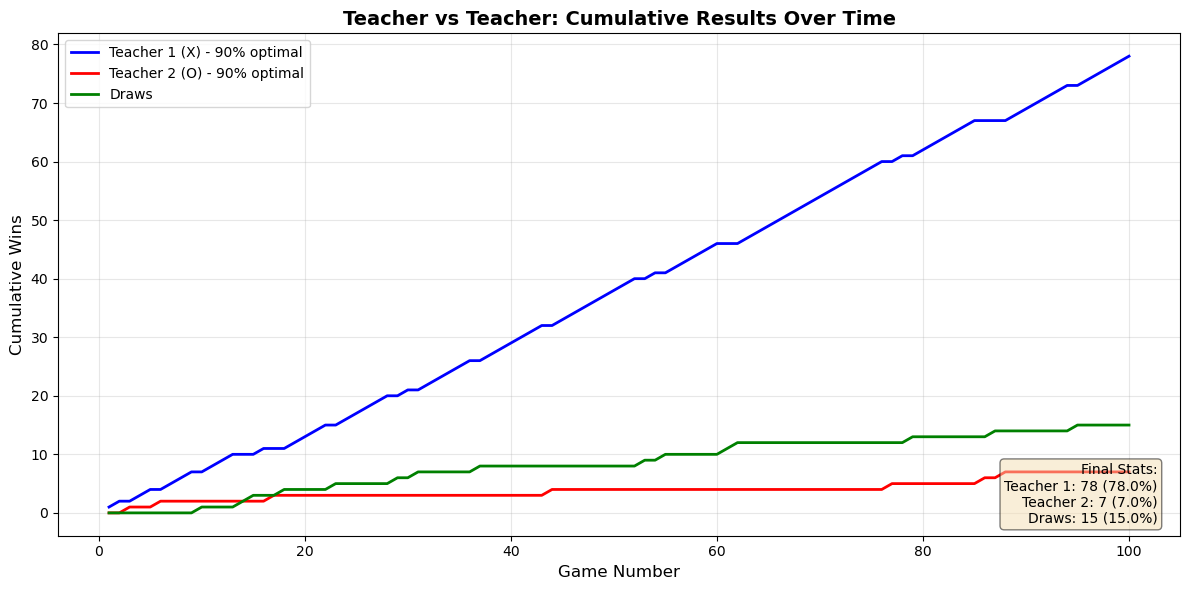

In [38]:
import matplotlib.pyplot as plt

def teacher_vs_teacher_analysis():
    """Run Teacher vs Teacher games and show graph"""
    
    def play_game(first_player, second_player, first_symbol, second_symbol):
        """Play a single game between two teachers"""
        state = emptystate()
        
        for i in range(9):
            if i % 2 == 0:
                move = first_player.action(state)
                state[move[0]][move[1]] = first_symbol
            else:
                move = second_player.action(state)
                state[move[0]][move[1]] = second_symbol
            
            winner = gameover(state)
            if winner != EMPTY:
                return winner
        
        return DRAW
    
    # Get user input for teacher configurations
    print("=" * 70)
    print("TEACHER vs TEACHER SETUP")
    print("=" * 70)

    # Configure Teacher 1 (X)
    print("\n--- Teacher 1 (plays as X) ---")
    while True:
        print("Teacher 1 difficulty level:")
        print("  1. Easy (50% optimal)")
        print("  2. Medium (75% optimal)")
        print("  3. Hard (90% optimal)")
        print("  4. Perfect (100% optimal)")
        choice = input("Enter choice (1-4): ").strip()
        if choice == '1':
            teacher1_level = 0.5
            break
        elif choice == '2':
            teacher1_level = 0.75
            break
        elif choice == '3':
            teacher1_level = 0.9
            break
        elif choice == '4':
            teacher1_level = 1.0
            break
        print("Invalid choice! Please enter 1, 2, 3, or 4.")

    # Configure Teacher 2 (O)
    print("\n--- Teacher 2 (plays as O) ---")
    while True:
        print("Teacher 2 difficulty level:")
        print("  1. Easy (50% optimal)")
        print("  2. Medium (75% optimal)")
        print("  3. Hard (90% optimal)")
        print("  4. Perfect (100% optimal)")
        choice = input("Enter choice (1-4): ").strip()
        if choice == '1':
            teacher2_level = 0.5
            break
        elif choice == '2':
            teacher2_level = 0.75
            break
        elif choice == '3':
            teacher2_level = 0.9
            break
        elif choice == '4':
            teacher2_level = 1.0
            break
        print("Invalid choice! Please enter 1, 2, 3, or 4.")

    # Ask for number of games
    while True:
        try:
            num_games = int(input("\nHow many games to play? (e.g., 100): ").strip())
            if num_games > 0:
                break
            print("Please enter a positive number.")
        except ValueError:
            print("Invalid input! Please enter a number.")
    
    # Create teacher objects
    teacher1 = Teacher(level=teacher1_level, player=PLAYER_X)
    teacher2 = Teacher(level=teacher2_level, player=PLAYER_O)
    
    print("=" * 70)
    print("TEACHER vs TEACHER")
    print("=" * 70)
    print(f"Teacher 1 (X): {teacher1_level*100:.0f}% optimal")
    print(f"Teacher 2 (O): {teacher2_level*100:.0f}% optimal")
    print(f"Playing {num_games} games...")
    print("=" * 70)
    
    # Play games
    teacher1_wins = 0
    teacher2_wins = 0
    draws = 0
    
    # Track results over time for graphing
    teacher1_wins_history = []
    teacher2_wins_history = []
    draws_history = []
    
    for i in range(num_games):
        winner = play_game(teacher1, teacher2, PLAYER_X, PLAYER_O)
        
        if winner == PLAYER_X:
            teacher1_wins += 1
        elif winner == PLAYER_O:
            teacher2_wins += 1
        else:
            draws += 1
        
        # Track cumulative results
        teacher1_wins_history.append(teacher1_wins)
        teacher2_wins_history.append(teacher2_wins)
        draws_history.append(draws)
        
        # Progress indicator
        if (i + 1) % 10 == 0:
            print(f"Progress: {i + 1}/{num_games} games")
    
    # Print final statistics
    print("\n" + "=" * 70)
    print("FINAL STATISTICS")
    print("=" * 70)
    print(f"Games played: {num_games}")
    print(f"Teacher 1 (X) wins: {teacher1_wins} ({teacher1_wins/num_games*100:.1f}%)")
    print(f"Teacher 2 (O) wins: {teacher2_wins} ({teacher2_wins/num_games*100:.1f}%)")
    print(f"Draws: {draws} ({draws/num_games*100:.1f}%)")
    print("=" * 70)
    
    # Create graph
    print("\nGenerating graph...")
    
    games = list(range(1, num_games + 1))
    
    plt.figure(figsize=(12, 6))
    
    plt.plot(games, teacher1_wins_history, label=f'Teacher 1 (X) - {teacher1_level*100:.0f}% optimal', linewidth=2, color='blue')
    plt.plot(games, teacher2_wins_history, label=f'Teacher 2 (O) - {teacher2_level*100:.0f}% optimal', linewidth=2, color='red')
    plt.plot(games, draws_history, label='Draws', linewidth=2, color='green')
    
    plt.xlabel('Game Number', fontsize=12)
    plt.ylabel('Cumulative Wins', fontsize=12)
    plt.title('Teacher vs Teacher: Cumulative Results Over Time', fontsize=14, fontweight='bold')
    plt.legend(loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    
    # Add final statistics as text on graph
    stats_text = f'Final Stats:\nTeacher 1: {teacher1_wins} ({teacher1_wins/num_games*100:.1f}%)\nTeacher 2: {teacher2_wins} ({teacher2_wins/num_games*100:.1f}%)\nDraws: {draws} ({draws/num_games*100:.1f}%)'
    plt.text(0.98, 0.02, stats_text, transform=plt.gca().transAxes,
             fontsize=10, verticalalignment='bottom', horizontalalignment='right',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    plt.tight_layout()
    plt.show()

# Run the analysis
teacher_vs_teacher_analysis()